# Analysis of Numerical Experiments

**Setting addressed by Montanari & Saeed '22**

Covariates $z_i$. Features $x_i = \phi(z_i)$ (e.g.: a random features model, or neural tangent kernel).

$$y_i = \eta({\Theta^*}^\top x_i)$$

Universality is established between $(X, y(X))$ and $(G, y(G))$, for gaussian equivalent features $g_i \sim \mathcal{N}(\mu_g, \Sigma_g)$.

**Setting addressed by Hu & Lu '22:**

Covariates $z_i$.

$$y_i = \eta(\langle \theta^*, z_i \rangle)$$

Universality is established between a random features model $x_i = \phi_{RF}(z_i)$, and a gaussian equivalent $g_i = \mu_0 \mathbf{1} + \mu_1 F^\top z_i + \mu_2 \nu_i$, where $F$ is the weights matrix of $\phi_{RF}$ and $\nu_i \sim \mathcal{N}(0, I_p)$

**Setting studied in these experiments:**

Covariates $z_i$. Generate a random neural network model $\mathrm{NeurNet}$. This is the ground truth response function, as a function of the covariates:
$$y_i = \mathrm{NeurNet}(z_i) + \varepsilon_i,$$

where $\varepsilon_i$ is zero-mean noise.

Universality is tested between the features generated by a random-features model, $x_i = \phi_{RF}(z_i)$, and gaussian-equivalent features, $g_i = \mu_0 \mathbf{1} + \mu_1 F^\top z_i + \mu_2 \nu_i$, where $F$ is the weights matrix of $\phi_{RF}$ and $\nu_i \sim \mathcal{N}(0, I_p)$.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import utils

In [2]:
import scienceplots
plt.style.use('seaborn-v0_8-colorblind')
plt.style.use('grid')

In [3]:
def plot_band(ax, x, data, sem_multiplier=2, label=None):
    y = np.mean(data, axis=1)
    y_err = sem_multiplier * scipy.stats.sem(data, axis=1)
    ax.plot(x, y, label=label, marker='.')
    ax.fill_between(x, y - y_err, y + y_err, alpha=0.5)


In [4]:
def plot_rf_gaussian_comparison(agg_runs_df, n_train, metric_name='mean_squared_error', y_var=None):

    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)

    metric = f'train_{metric_name}'
    for group in agg_runs_df.group.unique():
        group_df = agg_runs_df[agg_runs_df.group==group]
        
        x = group_df['p'] / n_train
        y = group_df[f'{metric} mean']
        y_err = 2*group_df[f'{metric} sem']

        ax1.plot(x, y, label=group, marker='.')

        ax1.fill_between(x, y - y_err, y + y_err, alpha=0.5)

    metric = f'test_{metric_name}'
    for group in agg_runs_df.group.unique():
        group_df = agg_runs_df[agg_runs_df.group==group]
        
        x = group_df['p'] / n_train
        y = group_df[f'{metric} mean']
        y_err = 2*group_df[f'{metric} sem']

        ax2.plot(x, y, label=group, marker='.')

        ax2.fill_between(x, y - y_err, y + y_err, alpha=0.5)

    if y_var:
        xmin, xmax = ax1.get_xlim()
        ax1.hlines(y=y_var, xmin=xmin, xmax=xmax, linestyles='dashed', colors='gray', label='$\mathrm{Var}(y)$')
        ax2.hlines(y=y_var, xmin=xmin, xmax=xmax, linestyles='dashed', colors='gray', label='$\mathrm{Var}(y)$')

    ax1.set_xlabel('$\gamma = p/n$');
    ax1.set_ylabel('Train MSE');
    ax1.legend(loc='upper right', fontsize='small', fancybox=True, frameon=True, framealpha=0.8);
    ax2.set_xlabel('$\gamma = p/n$');
    ax2.set_ylabel('Test MSE');
    ax2.legend(loc='upper right', fontsize='small', fancybox=True, frameon=True, framealpha=0.8);

    return fig, (ax1, ax2)

def get_y_variance(project_dir_name):
    path = f'results/{project_name}/random_feats.npy'
    data = np.load(path, allow_pickle=True).item()
    y_variance = np.var(data['y_test'])
    
    return y_variance

## Experiment: $y = \mathrm{NeurNet}(z)$, $\mathrm{NeurNet}$ a random 1-layer neural network (128-1)

Covariates $z_i \sim \mathcal{N}(0, I_d) \in \mathbb{R}^d$.

$$y_i = \mathrm{NeurNet}(z_i) + \varepsilon_i,$$

where $\varepsilon_i \sim \mathcal{N}(0, 0.01)$ is zero-mean measurement noise. The random neural network consists of 1 layer and uses the architecture $[128-1]$, with a $\tanh$ activation. 

We use the parameters $n = 1200, \ d= 400, \gamma \in [0.05, 2], \sigma_{RF} = \text{relu}, \ell(x,y) = (x-y)^2$.

In [5]:
project_name = 'results_nn_128_1_2023-04-24-0121'
y_var = get_y_variance(project_name)

In [6]:
runs_df = utils.get_wandb_project_table(project_name='universality-erm-random-neur-net-response (128-1)', entity='Awni00',
    attr_cols=('name',), config_cols='all', summary_cols='all')

In [7]:
agg_runs_df = runs_df.groupby(['group', 'p'])
metrics = ['train_mean_squared_error', 'test_mean_squared_error']
agg_runs_df = agg_runs_df[metrics].agg(
    [np.mean, np.max, scipy.stats.sem, len])

agg_runs_df = agg_runs_df.reset_index()
agg_runs_df.columns = [' '.join(col).strip() for col in agg_runs_df.columns.values]

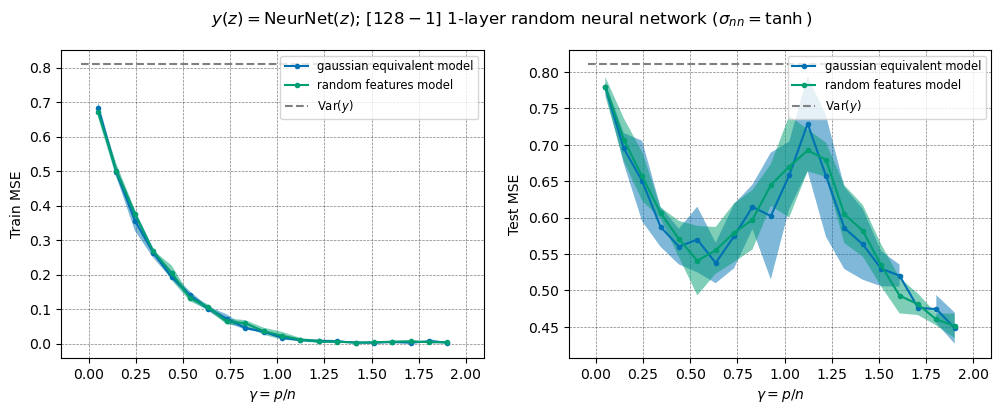

In [8]:
fig, _ = plot_rf_gaussian_comparison(agg_runs_df, n_train=1200, metric_name='mean_squared_error', y_var=y_var)

fig.suptitle('$y(z) = \\mathrm{NeurNet}(z)$; $[128-1]$ 1-layer random neural network ($\\sigma_{nn} = \\tanh$)');

fig.savefig(f'figs/{project_name}.pdf')

## Experiment: $y = \mathrm{NeurNet}(z)$, $\mathrm{NeurNet}$ a random 2-layer neural network (128-128-1)

Covariates $z_i \sim \mathcal{N}(0, I_d) \in \mathbb{R}^d$.

$$y_i = \mathrm{NeurNet}(z_i) + \varepsilon_i,$$

where $\varepsilon_i \sim \mathcal{N}(0, 0.01)$ is zero-mean measurement noise. The random neural network consists of 2 layers and uses the architecture $[128-128-1]$, with a $\tanh$ activation. 

We use the parameters $n = 1200, \ d= 400, \gamma \in [0.05, 2], \sigma_{RF} = \text{relu}, \ell(x,y) = (x-y)^2$.

In [9]:
project_name = 'results_nn_128_128_1_2023-04-24-0008'
y_var = get_y_variance(project_name)

In [10]:
runs_df = utils.get_wandb_project_table(project_name='universality-erm-random-neur-net-response (128-128-1)', entity='Awni00',
    attr_cols=('name',), config_cols='all', summary_cols='all')

In [11]:
agg_runs_df = runs_df.groupby(['group', 'p'])
metrics = ['train_mean_squared_error', 'test_mean_squared_error']
agg_runs_df = agg_runs_df[metrics].agg(
    [np.mean, np.max, scipy.stats.sem, len])

agg_runs_df = agg_runs_df.reset_index()
agg_runs_df.columns = [' '.join(col).strip() for col in agg_runs_df.columns.values]

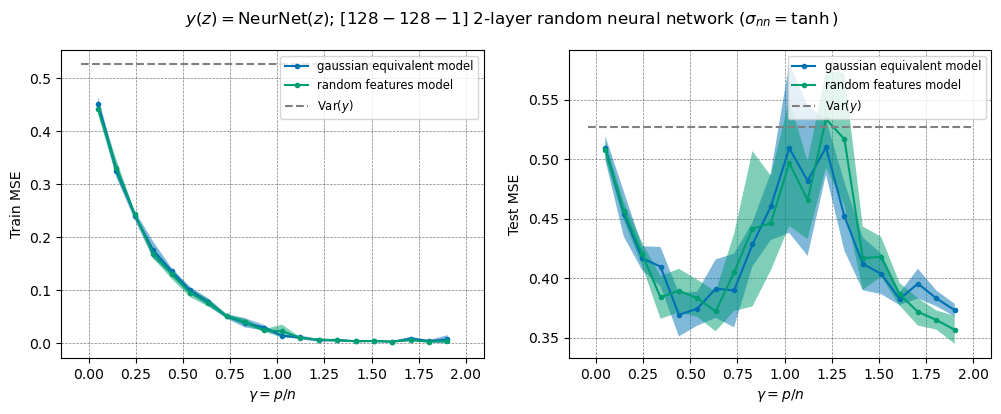

In [12]:
fig, _ = plot_rf_gaussian_comparison(agg_runs_df, n_train=1200, metric_name='mean_squared_error', y_var=y_var)

fig.suptitle('$y(z) = \\mathrm{NeurNet}(z)$; $[128-128-1]$ 2-layer random neural network ($\\sigma_{nn} = \\tanh$)');

fig.savefig(f'figs/{project_name}.pdf')

## Experiment: $y = \mathrm{NeurNet}(z)$, $\mathrm{NeurNet}$ a random 3-layer neural network (128-256-128-1)

Covariates $z_i \sim \mathcal{N}(0, I_d) \in \mathbb{R}^d$.

$$y_i = \mathrm{NeurNet}(z_i) + \varepsilon_i,$$

where $\varepsilon_i \sim \mathcal{N}(0, 0.01)$ is zero-mean measurement noise. The random neural network consists of 3 layers and uses the architecture $[128-256-128-1]$, with a $\mathrm{relu}$ activation. 

We use the parameters $n = 1200, \ d= 400, \gamma \in [0.05, 2], \sigma_{RF} = \tanh, \ell(x,y) = (x-y)^2$.

In [13]:
project_name = 'results_nn_128_256_128_1_2023-04-24-0011'
y_var = get_y_variance(project_name)

In [14]:
runs_df = utils.get_wandb_project_table(project_name='universality-erm-random-neur-net-response-128-256-128-1', entity='Awni00',
    attr_cols=('name',), config_cols='all', summary_cols='all')

In [15]:
agg_runs_df = runs_df.groupby(['group', 'p'])
metrics = ['train_mean_squared_error', 'test_mean_squared_error']
agg_runs_df = agg_runs_df[metrics].agg(
    [np.mean, np.max, scipy.stats.sem, len])

agg_runs_df = agg_runs_df.reset_index()
agg_runs_df.columns = [' '.join(col).strip() for col in agg_runs_df.columns.values]

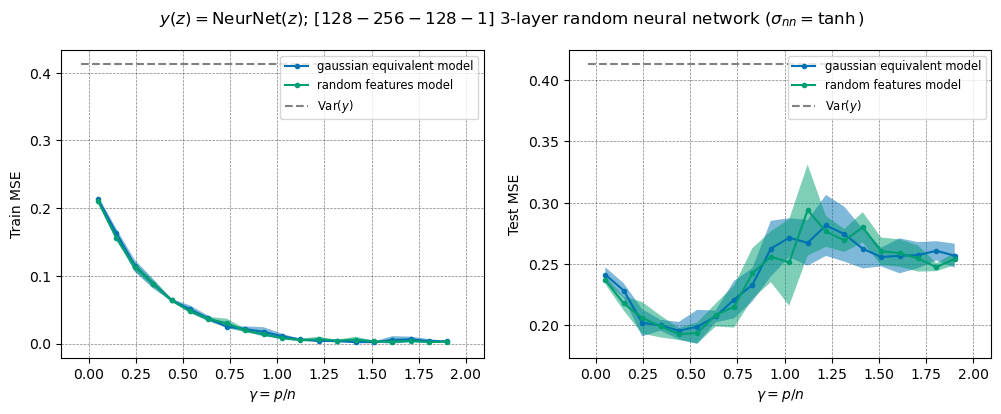

In [16]:
fig, _ = plot_rf_gaussian_comparison(agg_runs_df, n_train=1200, metric_name='mean_squared_error', y_var=y_var)

fig.suptitle('$y(z) = \\mathrm{NeurNet}(z)$; $[128-256-128-1]$ 3-layer random neural network ($\\sigma_{nn} = \\tanh$)');

fig.savefig(f'figs/{project_name}.pdf')

## Experiment: $y = \mathrm{NeurNet}(z)$, $\mathrm{NeurNet}$ a random 3-layer neural network (128-256-128-1) w/ $\mathrm{relu}$ activation

Covariates $z_i \sim \mathcal{N}(0, I_d) \in \mathbb{R}^d$.

$$y_i = \mathrm{NeurNet}(z_i) + \varepsilon_i,$$

where $\varepsilon_i \sim \mathcal{N}(0, 0.01)$ is zero-mean measurement noise. The random neural network consists of 3 layers and uses the architecture $[128-256-128-1]$, with a $\mathrm{relu}$ activation. 

We use the parameters $n = 1200, \ d= 400, \gamma \in [0.05, 2], \sigma_{RF} = \text{relu}, \ell(x,y) = (x-y)^2$.

In [17]:
project_name = 'results_nn_128_256_128_1_relu_2023-04-24-0244'
y_var = get_y_variance(project_name)

In [18]:
runs_df = utils.get_wandb_project_table(project_name='universality-erm-random-neur-net-response (128-256-128; relu)', entity='Awni00',
    attr_cols=('name',), config_cols='all', summary_cols='all')

In [19]:
agg_runs_df = runs_df.groupby(['group', 'p'])
metrics = ['train_mean_squared_error', 'test_mean_squared_error']
agg_runs_df = agg_runs_df[metrics].agg(
    [np.mean, np.max, scipy.stats.sem, len])

agg_runs_df = agg_runs_df.reset_index()
agg_runs_df.columns = [' '.join(col).strip() for col in agg_runs_df.columns.values]

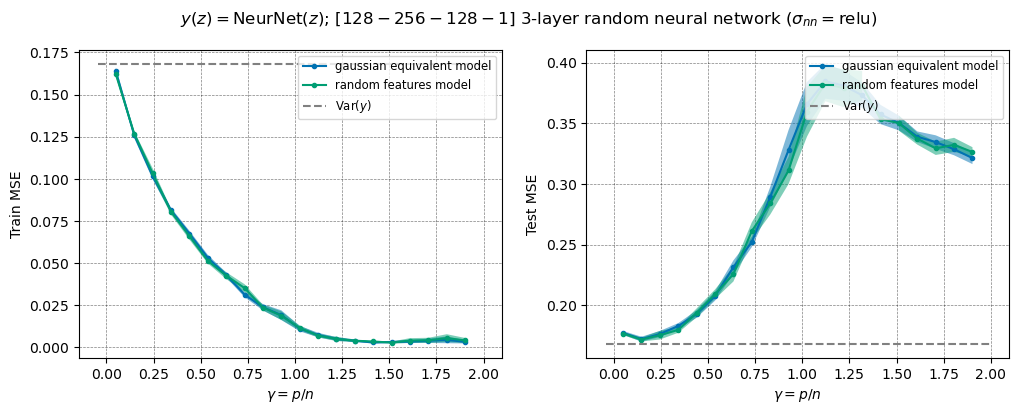

In [20]:
fig, _ = plot_rf_gaussian_comparison(agg_runs_df, n_train=1200, metric_name='mean_squared_error', y_var=y_var)

fig.suptitle('$y(z) = \\mathrm{NeurNet}(z)$; $[128-256-128-1]$ 3-layer random neural network ($\\sigma_{nn} = \\mathrm{relu}$)');

fig.savefig(f'figs/{project_name}.pdf')